In [1]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 0.08414846  0.16831254  0.21432212  0.2399553   0.29595018  0.33051429
  0.52251546  0.60181514  0.84906459  1.01233462  1.42809973  2.46635032
  4.8923083 ]


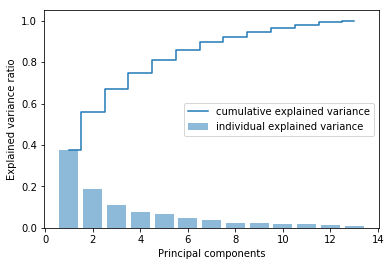

In [4]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
        label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
               for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

In [6]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.14669811  0.50417079]
 [ 0.24224554  0.24216889]
 [ 0.02993442  0.28698484]
 [ 0.25519002 -0.06468718]
 [-0.12079772  0.22995385]
 [-0.38934455  0.09363991]
 [-0.42326486  0.01088622]
 [ 0.30634956  0.01870216]
 [-0.30572219  0.03040352]
 [ 0.09869191  0.54527081]
 [-0.30032535 -0.27924322]
 [-0.36821154 -0.174365  ]
 [-0.29259713  0.36315461]]


In [7]:
X_train_pca = X_train_std.dot(w)

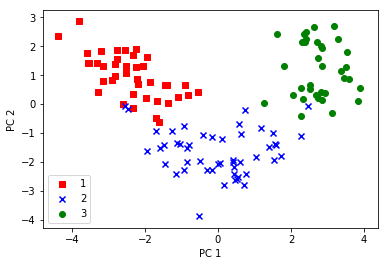

In [8]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.show()

In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

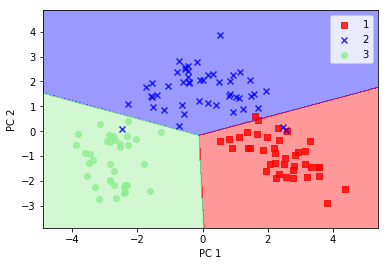

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.show()

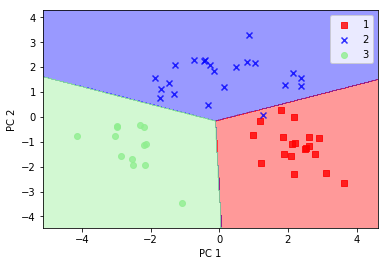

In [11]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.show()

In [12]:
np.set_printoptions(precision=4)
mean_vecs = {}
for label in np.unique(y_train):
    mean_vecs[label] = np.mean(X_train_std[y_train==label], axis=0)
    print('MV %s: %s\n' % (label, mean_vecs[label]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [13]:
d = 13 # number of features
S_W = np.zeros((d, d))
for key, value in mean_vecs.items():
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), value.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s'
      % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [14]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


In [15]:
d = 13
S_W = np.zeros((d, d))
for label in np.unique(y_train):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s'
      % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [16]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for key, value in mean_vecs.items():
    n = X_train_std[y_train==key, :].shape[0]
    mean_vec = value.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot(
           (mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' 
      % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [17]:
eigen_vals, eigen_vecs = np.linalg.eig(
    np.linalg.inv(S_W).dot(S_B))

In [19]:
mean_overall

array([[  2.8902e-15],
       [ -1.2556e-15],
       [  1.1451e-15],
       [  2.5625e-15],
       [ -3.2590e-16],
       [ -1.3511e-15],
       [  2.7756e-16],
       [ -1.6394e-15],
       [  1.0816e-15],
       [ -3.9395e-17],
       [ -1.8623e-16],
       [  1.0690e-15],
       [  2.2831e-17]])

In [ ]:
#somethings wrong - negative values